In [1096]:
import numpy as np
import pandas as pd
import cloudpickle as cp


df = pd.read_parquet("solar_cleaned.parquet")
md = cp.load(open("rfc.sav", 'rb'))
feature_pipeline = cp.load(open('feature_pipeline.sav', 'rb'))

In [1097]:
plot_data = df.sample(n=10000)
plot_data['id'] = plot_data.index

In [1098]:
from sklearn.metrics import r2_score

predictions = md.predict(feature_pipeline.fit_transform(plot_data))
print(r2_score(plot_data[['ghi_efficiency', 'dni_efficiency']].values, predictions))

0.6313312426695833


In [1099]:
pred = np.array([])
for row in md.predict(feature_pipeline.fit_transform(plot_data)):
    pred = np.append(pred, row[0])
    
real = np.array([])
for row in plot_data[['ghi_efficiency']].values.tolist():
    real = np.append(real, row[0])

pdata = pd.DataFrame({
    'error': abs(real - pred),
    'id': plot_data['id']
})

In [1100]:
subs = pdata[pdata['error'] > 0]

# merge data
les = plot_data[plot_data['id'].isin(subs['id'].unique())]
les = les.merge(subs)
les.head()

STATION       DATE  latitude  longitude  temperature  dew_point  \
0    12947 2017-03-22  28.45667  -99.21833    26.916667  15.750000   
1    12917 2017-07-08  29.95056  -94.02056    29.846154  23.615385   
2    53907 2017-07-19  32.66361  -97.09389    33.538462  20.615385   
3    53907 2017-04-24  32.66361  -97.09389    21.153846   8.000000   
4    53964 2017-06-15  33.25444  -97.58056    31.142857  22.500000   

   relative_humidity  hourly_precipitation  station_pressure  wind_speed  \
0          54.553333                 0.000         29.532500    4.483333   
1          71.641538                 0.000         30.065714    1.453846   
2          49.479231                 0.000         29.420769    2.369231   
3          46.105385                 0.000         29.180000    3.515385   
4          62.430000                 0.065         28.815714    3.664286   

   hourly_visibility  cloud_cover  dhi_efficiency  dni_efficiency  \
0           9.500000     0.458333        1.541625        0.570805   
1           9.982857     0.107692        1.272191        0.909328   
2          10.000000     0.076923        1.000000        1.000000   
3          10.000000     0.000000        1.446199        0.847162   
4          10.000000     0.000000        1.054847        0.856107   

   ghi_efficiency  mostly_cloudy  mostly_clear  clear  cloudy  partly_cloudy  \
0        0.764459            2.0           1.0    2.0     4.0            3.0   
1        0.971221            0.0           1.0    8.0     0.0            4.0   
2        1.000000            0.0           5.0    8.0     0.0            0.0   
3        0.944712            0.0           0.0   13.0     0.0            0.0   
4        0.957356            0.0           0.0   14.0     0.0            0.0   

   overcast  rain_light  tstorm  drizzle  rain_heavy  rain  fog  snow_light  \
0       0.0         0.0     0.0      1.0         0.0   0.0  0.0         0.0   
1       0.0         0.0     2.0      0.0         0.0   0.0  0.0         0.0   
2       0.0         0.0     0.0      0.0         0.0   0.0  0.0         0.0   
3       0.0         0.0     0.0      0.0         0.0   0.0  0.0         0.0   
4       0.0         0.0     0.0      0.0         0.0   0.0  0.0         0.0   

   snow  snow_heavy  freezing_rain  ice_pellets  ice_pellets_light  \
0   0.0         0.0            0.0          0.0                0.0   
1   0.0         0.0            0.0          0.0                0.0   
2   0.0         0.0            0.0          0.0                0.0   
3   0.0         0.0            0.0          0.0                0.0   
4   0.0         0.0            0.0          0.0                0.0   

   freezing_drizzle  ice_pellets_heavy  flurries  freezing_rain_heavy  \
0               0.0                0.0       0.0                  0.0   
1               0.0                0.0       0.0                  0.0   
2               0.0                0.0       0.0                  0.0   
3               0.0                0.0       0.0                  0.0   
4               0.0                0.0       0.0                  0.0   

   freezing_rain_light  fog_light     id     error  
0                  0.0        0.0  40912  0.033094  
1                  0.0        0.0  37148  0.207295  
2                  0.0        0.0  76583  0.044845  
3                  0.0        0.0  76497  0.019628  
4                  0.0        0.0  81125  0.114662

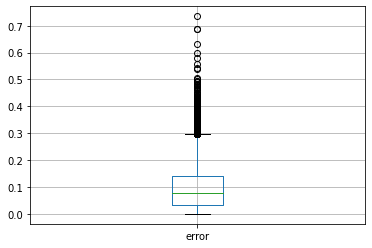

In [1101]:
pdata.boxplot('error')

In [1102]:
import altair as alt

hist = alt.Chart(subs[:5000]).mark_bar().encode(
    alt.X("error:Q", bin=alt.Bin(maxbins=100)),
    y='count()'
).interactive()

rule = alt.Chart(subs[:5000]).mark_rule(color='red').encode(
    x='mean(error):Q',
    size=alt.value(2)
)

hist + rule

alt.LayerChart(...)

In [1103]:
from ipyleaflet import Map, Heatmap, Marker, MarkerCluster
m = Map(center=[44, -90], zoom=6)

for row in les.sample(n=1000).iterrows():
    circle_marker = CircleMarker()
    circle_marker.location = (row[1][2], row[1][3])
    circle_marker.radius = int(row[1][39] * 25)
    circle_marker.fill = False
    circle_marker.weight = 2
    m.add_layer(circle_marker)

m

Map(center=[44, -90], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [1104]:
s = les.sample(5000).copy()
s['month'] = pd.DatetimeIndex(s['DATE']).month

alt.Chart(s).mark_bar().encode(
    alt.X("month", bin=alt.Bin(maxbins=12)),
    y='mean(error):Q')

alt.Chart(...)